In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/U_net"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Challenge  IMA205.ipynb  j.h5  U_net01	U_net01pbinputtraining.ipynb


In [0]:
#cd "gdrive/My Drive/Challenge/


In [0]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D, BatchNormalization,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import InceptionV3
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from keras import regularizers
from scipy.ndimage import imread
import numpy as np
import cv2





In [38]:
%cd "/content/gdrive/My Drive/U_net/Challenge"


/content/gdrive/My Drive/U_net/Challenge


In [39]:
df = pd.read_csv('data/train.csv')
X_df = df['ImageId']
y_df = df['Malignant']
X = X_df.values
y = y_df.values
print ( 'We have ',len(X),' training sample')

We have  700  training sample


In [40]:

batch_size= 16
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, 
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.09,
    horizontal_flip=True,
    vertical_flip=True)




# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')




Found 627 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [0]:
#trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

# data_gen = ImageDataGenerator(
#         rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally
#         height_shift_range=0.1,  # randomly shift images vertically
#         horizontal_flip=True, 
#         vertical_flip=True)
# #x = imageLoader(trainset,batch_size)
# data_gen.fit(train_generator)

In [41]:
input_shape = (224, 224, 3)

num_labels = 2

base_model = InceptionV3(include_top=False, input_shape=input_shape ,pooling = 'avg')
i = 0
for layer in base_model.layers:
    if i % 10 == 5:
       layer.trainable = True
    i+=1    

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(1, activation = 'relu'))


model.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 22,065,317
Trainable params: 22,030,885
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
from tensorflow.python.keras.optimizers import Adam
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [43]:
import keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("name-of-model-%d.h5" %epoch)
            
checkpoint = CustomModelCheckPoint()
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = 'after_incep1.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
epochs = 5 
batch_size = 20

history = model.fit_generator(
        train_generator,
        steps_per_epoch=800 // batch_size,
        epochs=12,
        validation_data=validation_generator,
        validation_steps=75 // batch_size, callbacks=[cb_checkpointer, cb_early_stopper])



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/12
40/40 [==============================] - 104s 3s/step - loss: 3.2076 - acc: 0.6348 - val_loss: 8.1920 - val_acc: 0.5890
Epoch 2/12
40/40 [==============================] - 110s 3s/step - loss: 2.1526 - acc: 0.7416 - val_loss: 2.1803 - val_acc: 0.6164
Epoch 3/12
40/40 [==============================] - 110s 3s/step - loss: 1.7404 - acc: 0.7273 - val_loss: 1.9840 - val_acc: 0.6027
Epoch 4/12
40/40 [==============================] - 109s 3s/step - loss: 1.4783 - acc: 0.6970 - val_loss: 1.8175 - val_acc: 0.6575
Epoch 5/12
40/40 [==============================] - 108s 3s/step - loss: 1.2529 - acc: 0.7209 - val_loss: 1.1685 - val_acc: 0.6575
Epoch 6/12
40/40 [==============================] - 109s 3s/step - loss: 1.0613 - acc: 0.7783 - val_loss: 1.3503 - val_acc: 0.5890
Epoch 7/12
40/40 [==============================] - 109s 3s/step - loss: 0.9286 - acc: 0.7719 - val_loss: 1.3286 - val_acc: 0.6164
Epoch 8/12
40/40 [==============================] - 107s 3s/step - loss: 0.8291 - a

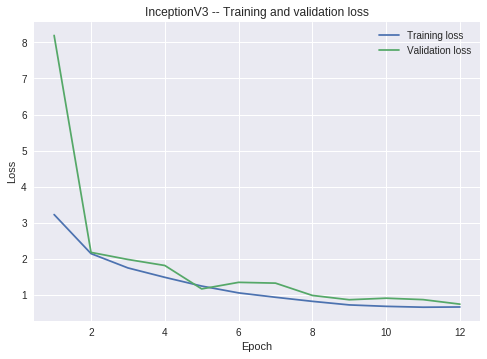

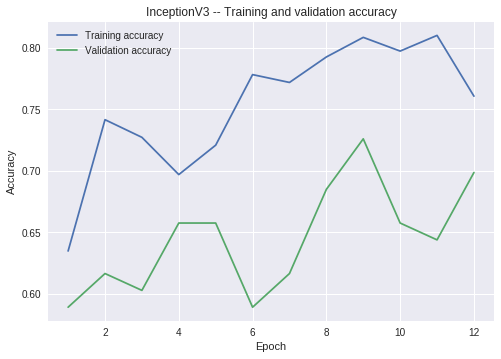

In [44]:
import matplotlib.pyplot as plt
trainhistory = history
acc = trainhistory.history['acc']
val_acc = trainhistory.history['val_acc']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('InceptionV3 -- Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('InceptionV3 -- Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
def binarize(L):
  S= np.zeros(len(L))
  for i in range(len(L)):
    if L[i]>0.5:
      S[i] = 1
  return S


def submit_test ( model, name_submission, test_folder_path):

    images = [f for f in os.listdir(test_folder_path) if os.path.isfile(os.path.join(test_folder_path, f))]

    l_im = []
    l_name_test = []
    for image in images:
            im_path = os.path.join(test_folder_path, image)
            im = imread(im_path)
            l_im.append( cv2.resize(im, (224,224)))
            l_name_test.append(image)


    
    l_im_test = np.asarray(l_im)
    l_im_test.shape
    pred = model.predict(l_im_test)
    test_df = pd.read_csv("data/test.csv")
    pred_finale = binarize(pred)
    pred_finale = [int(i) for i in pred_finale]

    l_names_final = []
    l_labels_final = []
    for index, row in test_df.iterrows():
         l_names_final.append(row['ImageId'])   
         i = l_name_test.index( row['ImageId'] + '.jpg')
         l_labels_final.append (pred_finale[i]) 

    d = {'ImageId': l_names_final, 'Malignant': l_labels_final}
    df_response = pd.DataFrame(data=d)
    df_response.to_csv(name_submission + ".csv", index= False)
    return df_response

In [25]:
submit_test (model,"sub", "test")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


,ImageId,Malignant
0,IM_000788,0
1,IM_000640,1
2,IM_000889,0
3,IM_000550,0
4,IM_000886,0
5,IM_000488,1
6,IM_000147,1
7,IM_000146,1
8,IM_000720,1
9,IM_000931,1
